# Project 3

实现马尔可夫逻辑网络的 MCMC 算法，展示至少 10 个案例。


**References:**

- (C++ Implementation of MLN) https://alchemy.cs.washington.edu/
- (MLN Syntax) https://alchemy.cs.washington.edu/user-manual/4_2MLN_Syntax.html
- (MLN Examples) https://alchemy.cs.washington.edu/tutorial/tutorial.pdf


## Introduction


A Markov logic network (MLN) $L$ is a set of pairs $(F_i, w_i)$, where $F_i$ is a formula in first-order logic and $w_i$ is a real number representing the weight of formula $F_i$. Together with a finite set of constant symbols $C$, it defines a ground Markov network $M_{L,C}$ as follows:

1. $M_{L,C}$ contains one node (variable) $x_i \in \{0, 1\}$ for each possible grounding of the atoms (predicates) in $L$ with constants from $C$.

2. $M_{L,C}$ contains one edge between each pair of nodes $(x_i, x_j)$ that appear together in a ground formula of $L$; that is, each ground formula of $L$ defines a clique $k$ in $M_{L,C}$.

3. $M_{L,C}$ contains one feature $n_i(x)$ for each formula $F_i$ in $L$, which is defined as th number of satisfied groundings of $F_i$ in $x$ and inherits the weight $w_i$ from $L$.

   Alternatively, we can think of $M_{L,C}$ as having one potential function $\phi_k(x_{\{k\}}) = \exp\left\{w_{i_k} \mathbb{I}_k(x_{\{k\}})\right\}$ for each clique $k\in \mathrm{cl}(M_{L,C})$, where $x_{\{k\}}$ is the state of the clique, and $\mathbb{I}_k(x_{\{k\}})$ indicates the truth value of $F_{i_k} \in L$ given a grounding assignment $x_{\{k\}}$.

   The joint probability of a state $x$ in $M_{L,C}$ is then given by

   $$P(x) \propto \prod_{k\in \mathrm{cl}(M_{L,C})} \phi_k(x_{\{k\}}) = \exp \left(\sum_{i=1}^{|L|} w_i n_i(x) \right).$$

An example of ground Markov network is shown below:

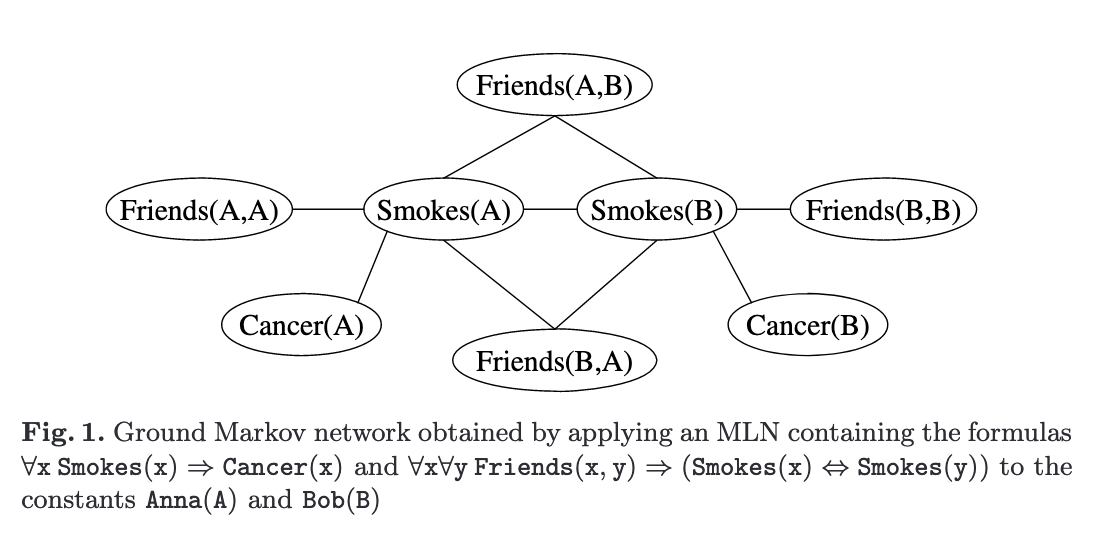

The key inference task we consider is to query a subset of ground atoms $Y$ in the ground Markov network $M_{L,C}$ given evidence of another subset of ground atoms $E$, i.e., to compute the conditional distribution $P(Y|E)$.
The most widely used method for approximate inference in this setting is Markov chain Monte Carlo (MCMC), and in particular Gibbs sampling, which proceeds by sampling each variable $z\in M_{L,C}\setminus E$ in turn given its Markov blanket $\mathrm{MB}(z)$ (in a Markov network, this is simply the node’s neighbors).

<hr />
<b>Algorithm:</b> Gibbs Sampling for Markov Logic Networks
<hr />

**Input:** a Markov logic network $L = \{(F_i, w_i)\}$; a set of constants $C$; a set of query variables $Y$ with unobserved truth values; a set of evidence variables $E$ with observed truth values; a number of iterations $T$. <br />
**Output:** the conditional distribution $P(Y|E)$. <br />

1. Construct the ground Markov network $M_{L,C}$.
2. Set the truth value of all $e\in E$.
3. Randomly initialize all $z \in M_{L,C}\setminus E$.
4. **for** $t \gets 1$ **to** $T$ **do**
5. &emsp; **for each** $z \in M_{L,C}\setminus E$ **do**
6. &emsp; &emsp; Sample $z \sim P(z|\mathrm{MB}(z))$.
7. &emsp; Increase the count of the current state of $Y$ by 1.
8. Set $P(Y|E)$ to be the normalized count (frequncy) of each state of $Y$.

<hr />


## Declaration of FOL and MLN


In [1]:
from functools import total_ordering
from dataclasses import dataclass
from copy import deepcopy
from typing import ClassVar


@dataclass(frozen=True, repr=False, eq=False)
@total_ordering
class Connective:
    name: str
    symbol: str
    priority: int

    def __str__(self):
        return self.symbol

    def __repr__(self):
        return self.name

    def __lt__(self, other):
        return other is None or self.priority < other.priority

    def __eq__(self, other):
        return self.priority == other.priority

    def __deepcopy__(self, _):
        return self


NOT = Connective('not', '!', 4)
AND = Connective('and', '&', 3)
OR = Connective('or', '|', 2)
IMPLIES = Connective('implies', '->', 1)
IFF = Connective('iff', '<->', 0)


class Formula:
    def unique_predicates(self):
        pass

    def unique_atoms(self):
        pass

    def unique_terms(self):
        pass


@dataclass(frozen=True, repr=False, order=True)
class Atom(Formula):
    connective: ClassVar = None
    formulas: ClassVar = tuple()
    predicate: str
    terms: tuple[str]

    def __str__(self):
        return f'{self.predicate}({", ".join(self.terms)})'

    def __repr__(self):
        return str(self)

    def __contains__(self, atom):
        return atom == self

    def unique_predicates(self):
        return set([self.predicate])

    def unique_atoms(self):
        return set([self])

    def unique_terms(self):
        return set(self.terms)


@dataclass(unsafe_hash=True, repr=False)
class Compound(Formula):
    connective: Connective
    formulas: tuple[Formula]

    def __str__(self):
        if self.connective is NOT:
            f = self.formulas[0]
            substr = f'({f})' if f.connective < self.connective else str(f)
            return f'{self.connective}{substr}'
        else:
            substrs = [
                f'({f})' if f.connective < self.connective else str(f)
                for f in self.formulas
            ]
            return f' {self.connective} '.join(substrs)

    def __repr__(self):
        return str(self)

    def __contains__(self, atom):
        return atom in self.unique_atoms()

    def unique_predicates(self):
        return set([p for f in self.formulas for p in f.unique_predicates()])

    def unique_atoms(self):
        return set([a for f in self.formulas for a in f.unique_atoms()])

    def unique_terms(self):
        return set([e for f in self.formulas for e in f.unique_terms()])

In [2]:
@dataclass
class MLN:
    weights: list[float]
    formulas: list[Formula]

    def __str__(self):
        return '\n'.join([f'{w} {f}' for w, f in zip(self.weights, self.formulas)])


@dataclass
class Program:
    mln: MLN
    evidence: list[Formula]
    query: list[Atom]

    def __post_init__(self):
        self.constants = self.unique_constants()

    def __str__(self):
        mln = zip(self.mln.weights, self.mln.formulas)
        return (
            'MLN:\n  '
            + '\n  '.join([f'{w} {f}' for w, f in mln])
            + '\nEvidence:\n  '
            + '\n  '.join([str(e) for e in self.evidence])
            + '\nQuery:\n  '
            + '\n  '.join([str(q) for q in self.query])
        )

    def unique_constants(self):
        constants = set()
        for formula in self.evidence:
            constants |= formula.unique_terms()
        for atom in self.query:
            constants |= atom.unique_terms()
        return constants

    def has_evidence(self, ground_atom: Atom):
        return any(ground_atom in formula for formula in self.evidence)

## Parsing MLN with Backus-Naur Form

We use Lark, a context-free parsing toolkit for Python, to parse our self-defined MLN syntax with BNF. 

A program contains 3 parts:
- The MLN, with each line consisting of a formula and its weight.
- The evidence, which in our case can only be a set of ground literals.
- The query atoms.


In [3]:
from lark import Lark, Transformer

BNF = r'''
// Markov Logic Network Syntax
start:              mln evidence query

mln:                ([NUMBER] _formula)+
evidence:           "evidence:" _ground_formula*
query:              "query:" ground_atom+

_formula:           iff_res{atom}
_ground_formula:    iff_res{ground_atom}

?paren_res{x}:      x | "(" iff_res{x} ")"
?not_res{x}:        paren_res{x} | "!" not_res{x} -> not_
?and_res{x}:        not_res{x} | and_res{x} ("&" not_res{x})+ -> and_
?or_res{x}:         and_res{x} | or_res{x} ("|" and_res{x})+ -> or_
?implies_res{x}:    or_res{x} | implies_res{x} "->" or_res{x} -> implies_
?iff_res{x}:        implies_res{x} | iff_res{x} "<->" implies_res{x} -> iff_

atom:               _predicate "(" _variables ")"
ground_atom:        _predicate "(" _constants ")"

_variables:         (_variable ("," _variable)*)?
_constants:         (_constant ("," _constant)*)?

_variable:          NAME
_constant:          CONSTANT
_predicate:         NAME

NAME:               /(?!evidence|query)[a-zA-Z_][a-zA-Z_0-9]*/
CONSTANT:           NAME | NUMBER

%import common.NUMBER
%import common.WS
%import common.WS_INLINE
%import common.NEWLINE
%import common.CPP_COMMENT

%ignore WS
%ignore CPP_COMMENT
'''


class MLNTransformer(Transformer):
    def start(self, parts):
        mln, evidence, query = parts
        return Program(mln=mln, evidence=evidence, query=query)

    def mln(self, pairs):
        weights = pairs[::2]
        formulas = pairs[1::2]
        return MLN(weights=weights, formulas=formulas)

    def evidence(self, ground_formulas):
        return ground_formulas

    def query(self, ground_atoms):
        return ground_atoms

    def not_(self, formulas):
        return Compound(NOT, formulas)

    def and_(self, formulas):
        return Compound(AND, formulas)

    def or_(self, formulas):
        return Compound(OR, formulas)

    def implies_(self, formulas):
        return Compound(IMPLIES, formulas)

    def iff_(self, formulas):
        return Compound(IFF, formulas)

    def atom(self, tokens):
        return Atom(tokens[0], tuple(tokens[1:]))

    def ground_atom(self, tokens):
        return Atom(tokens[0], tuple(tokens[1:]))

    def NAME(self, token):
        return token.value

    def NUMBER(self, token):
        return float(token.value)

    def CONSTANT(self, token):
        return str(token.value)


parser = Lark(BNF, parser='lalr', transformer=MLNTransformer())

source = r'''
1.5 Smokes(x) -> Cancer(x)
1.1 Friends(x, y) -> (Smokes(x) <-> Smokes(y))
evidence: Smokes(A) Friends(A, B) Friends(B, A)
query: Smokes(B) Cancer(B)
'''
program: Program = parser.parse(source)
print(program)

MLN:
  1.5 Smokes(x) -> Cancer(x)
  1.1 Friends(x, y) -> (Smokes(x) <-> Smokes(y))
Evidence:
  Smokes(A)
  Friends(A, B)
  Friends(B, A)
Query:
  Smokes(B)
  Cancer(B)


## Knowledge-Based Model Construction

Following the idea of KBMC, we construct the minimum subset of network needed to answer query, which cuts down the unnecessary memory usage to a large extent.


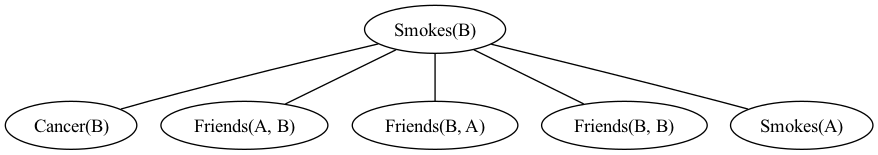

Nodes:           [Smokes(B), Cancer(B), Friends(A, B), Friends(B, A), Friends(B, B), Smokes(A)]
Observed IDs:    [5, 2, 3]
Unobserved IDs:  [0, 1, 4]


In [4]:
import numpy as np
import networkx as nx

from itertools import product
from queue import Queue
from networkx import Graph
from tabulate import tabulate
from IPython.display import Image


def atom_unify(self: Atom, other: Atom):
    if self.predicate != other.predicate:
        return None
    subst = {}
    for x, y in zip(self.terms, other.terms):
        if x in subst:
            if subst[x] != y:
                return None
        else:
            subst[x] = y
    return subst


def atom_subst(self: Atom, subst: dict):
    return Atom(self.predicate, tuple(subst.get(t, t) for t in self.terms))


def compound_subst(self: Compound, subst: dict):
    return Compound(self.connective, tuple(f.subst(subst) for f in self.formulas))


def formula_ground_by_atom(self: Formula, ground_atom: Atom, constants: set):
    substs: list[dict] = []
    vars = self.unique_terms()
    for atom in self.unique_atoms():
        subst = atom.unify(ground_atom)
        if subst is None:
            continue
        other_vars = vars - atom.unique_terms()
        for values in product(constants, repeat=len(other_vars)):
            other_subst = dict(zip(other_vars, values))
            substs.append(subst | other_subst)
    return substs


def program_ground_by_atom(self: Program, ground_atom: Atom):
    groundings = set()  # (formula_index, substitution)
    for i, formula in enumerate(self.mln.formulas):
        substs = formula.ground_by_atom(ground_atom, self.constants)
        groundings |= {(i, tuple(sorted(subst.items()))) for subst in substs}
    groundings -= self.groundings
    self.groundings |= groundings
    return [(i, dict(subst)) for i, subst in groundings]


def program_ground_and_get_neighbors(self: Program, ground_atom: Atom):
    neighbors = set()
    groundings = self.ground_by_atom(ground_atom)
    for formula_index, subst in groundings:
        formula = self.mln.formulas[formula_index].subst(subst)
        self.ground_formulas.append(formula)
        self.ground_weights.append(self.mln.weights[formula_index])
        neighbors |= formula.unique_atoms()
    neighbors.discard(ground_atom)
    return sorted(neighbors)


def program_build_ground_network(self: Program):
    self.groundings = set()
    self.ground_formulas = []
    self.ground_weights = []

    # knowledge-based model construction
    self.graph = Graph()
    queue = Queue()
    visited = set()
    for atom in self.query:
        self.graph.add_node(atom)
        queue.put(atom)
    while not queue.empty():
        atom = queue.get()
        if atom in visited or self.has_evidence(atom):
            continue
        visited.add(atom)
        neighbors = self.ground_and_get_neighbors(atom)
        for other_atom in neighbors:
            self.graph.add_edge(atom, other_atom)
            queue.put(other_atom)

    # initialize attributes for inference
    self.atom_to_id = {atom: i for i, atom in enumerate(self.graph)}
    self.id_to_atom = {i: atom for atom, i in self.atom_to_id.items()}
    self.assignment = np.zeros(len(self.graph), dtype=bool)
    self.obs_ids = []
    for formula in self.evidence:
        if formula.connective is None:
            if formula not in self.atom_to_id:
                continue
            id = self.atom_to_id[formula]
            self.assignment[id] = True
        elif formula.connective is NOT:
            if formula.formulas[0] not in self.atom_to_id:
                continue
            id = self.atom_to_id[formula.formulas[0]]
            self.assignment[id] = False
        else:
            raise NotImplementedError('Evidence formula can only be a literal.')
        self.obs_ids.append(id)
    self.unobs_ids = list(set(range(len(self.graph))) - set(self.obs_ids))
    self.query_ids = [self.atom_to_id[atom] for atom in self.query]


def graph_draw(self: Graph):
    display(Image(nx.nx_agraph.to_agraph(self).draw(format='png', prog='dot')))


Atom.unify = atom_unify
Atom.subst = atom_subst
Compound.subst = compound_subst
Formula.ground_by_atom = formula_ground_by_atom
Program.ground_by_atom = program_ground_by_atom
Program.ground_and_get_neighbors = program_ground_and_get_neighbors
Program.build_ground_network = program_build_ground_network
Graph.draw = graph_draw

self = program
self.build_ground_network()
self.graph.draw()

print('Nodes:          ', self.graph.nodes)
print('Observed IDs:   ', self.obs_ids)
print('Unobserved IDs: ', self.unobs_ids)

## Convert to Conjunctive Normal Form

For convenience of representation and model checking, we convert each ground formula to CNF by applying the following 3 steps:

1. Eliminate implications and equivalences.
2. Push negations inwards using De Morgan’s laws.
3. Distribute disjunctions over conjunctions.

Then, we convert each ground clause to DIMACS format, where each positive literal is denoted by a positive index and each negative literal is denoted by a negative index. By doing so, we represent each CNF in a more compact way and it is easier to manipulate.


In [5]:
from itertools import chain


def formula_to_cnf(self: Formula, inplace=False):
    c = self if inplace else deepcopy(self)
    c.eliminate_iff(inplace=True)
    c.eliminate_implies(inplace=True)
    c.push_down_not(inplace=True)
    c.distribute_or_over_and(inplace=True)
    if not inplace:
        return c


def formula_eliminate_iff(self: Formula, inplace=False):
    c = self if inplace else deepcopy(self)
    if c.connective is IFF:
        c.connective = AND
        c.formulas = [
            Compound(IMPLIES, c.formulas),
            Compound(IMPLIES, tuple(reversed(c.formulas))),
        ]
    for f in c.formulas:
        f.eliminate_iff(inplace=True)
    if not inplace:
        return c


def formula_eliminate_implies(self: Formula, inplace=False):
    c = self if inplace else deepcopy(self)
    if c.connective is IMPLIES:
        c.connective = OR
        c.formulas = [
            Compound(NOT, c.formulas[0:1]),
            c.formulas[1],
        ]
    for f in c.formulas:
        f.eliminate_implies(inplace=True)
    if not inplace:
        return c


def formula_push_down_not(self: Formula, inplace=False):
    c = self if inplace else deepcopy(self)
    if c.connective is NOT:
        f = c.formulas[0]
        if f.connective is AND:
            c.connective = OR
            c.formulas = tuple(Compound(NOT, (f,)) for f in f.formulas)
        elif f.connective is OR:
            c.connective = AND
            c.formulas = tuple(Compound(NOT, (f,)) for f in f.formulas)
    for f in c.formulas:
        f.push_down_not(inplace=True)
    if not inplace:
        return c


def formula_distribute_or_over_and(self: Formula, inplace=False):
    c = self if inplace else deepcopy(self)
    if c.connective is OR:
        clauses = [c.formulas]
        for i, f in enumerate(c.formulas):
            if f.connective is AND:
                clauses = [
                    (*clause[:i], x, *clause[i + 1 :])
                    for x in f.formulas
                    for clause in clauses
                ]
        if len(clauses) > 1:
            c.connective = AND
            c.formulas = [Compound(OR, clause) for clause in clauses]
    for f in c.formulas:
        f.distribute_or_over_and(inplace=True)
    if not inplace:
        return c


Formula.to_cnf = formula_to_cnf
Formula.eliminate_iff = formula_eliminate_iff
Formula.eliminate_implies = formula_eliminate_implies
Formula.push_down_not = formula_push_down_not
Formula.distribute_or_over_and = formula_distribute_or_over_and

print('Ground CNFs:', end='\n  ')
print(*(f.to_cnf() for f in self.ground_formulas), sep='\n  ')

Ground CNFs:
  (!Friends(A, B) | !Smokes(A) | Smokes(B)) & (!Friends(A, B) | !Smokes(B) | Smokes(A))
  !Smokes(B) | Cancer(B)
  (!Friends(B, B) | !Smokes(B) | Smokes(B)) & (!Friends(B, B) | !Smokes(B) | Smokes(B))
  (!Friends(B, A) | !Smokes(B) | Smokes(A)) & (!Friends(B, A) | !Smokes(A) | Smokes(B))


In [6]:
@dataclass(frozen=True, repr=False)
class Clause:
    literals: np.ndarray
    weight: float

    def __str__(self):
        return f'{self.literals}'

    def __repr__(self):
        return str(self)

    @property
    def indices(self):
        return np.abs(self.literals) - 1

    @property
    def signs(self):
        return np.sign(self.literals)


def program_convert_clauses(self: Program):
    def literal_to_num(literal):
        return (
            -literal_to_num(literal.formulas[0])
            if literal.connective is NOT
            else self.atom_to_id[literal] + 1
        )

    def clause_to_nums(clause):
        if clause.connective is OR:
            nums = [clause_to_nums(literal) for literal in clause.formulas]
            return set(chain.from_iterable(nums))
        else:
            return {literal_to_num(clause)}

    def cnf_to_nums(cnf):
        if cnf.connective is AND:
            nums = [cnf_to_nums(clause) for clause in cnf.formulas]
            return set(chain.from_iterable(nums))
        else:
            clause = clause_to_nums(cnf)
            pos = {x for x in clause if x > 0}
            neg = {-x for x in clause if x < 0}
            if pos & neg:
                return set()
            return {tuple(sorted(clause_to_nums(cnf)))}

    self.cnf_nums = [tuple(cnf_to_nums(f.to_cnf())) for f in self.ground_formulas]
    self.clauses = [
        Clause(np.array(clause), self.ground_weights[i] / len(cnf))
        for i, cnf in enumerate(self.cnf_nums)
        for clause in cnf
    ]

    # get occurrences (indices of containing clauses) of each literal
    self.occurs = {i: set() for i in range(1, len(self.graph) + 1)}
    self.occurs |= {-i: set() for i in range(1, len(self.graph) + 1)}
    for i, clause in enumerate(self.clauses):
        for literal in clause.literals:
            self.occurs[literal].add(i)
    for i in range(1, len(self.graph) + 1):
        intersect = self.occurs[i] & self.occurs[-i]
        self.occurs[i] -= intersect
        self.occurs[-i] -= intersect
    self.occurs = {i: tuple(occ) for i, occ in self.occurs.items()}


Program.convert_clauses = program_convert_clauses

self.convert_clauses()

table = tabulate(
    [
        (
            parent_id,
            ', '.join(str(t) for t in subst),
            self.ground_formulas[i],
            ', '.join(str(t) for t in self.cnf_nums[i]),
            self.ground_weights[i],
        )
        for i, (parent_id, subst) in enumerate(self.groundings)
    ],
    headers=['Parent Index', 'Substitution', 'Ground Formula', 'DIMACS CNF', 'Weight'],
)
print(table)

  Parent Index  Substitution            Ground Formula                              DIMACS CNF                  Weight
--------------  ----------------------  ------------------------------------------  ------------------------  --------
             1  ('x', 'A'), ('y', 'B')  Friends(A, B) -> (Smokes(A) <-> Smokes(B))  (-3, -1, 6), (-6, -3, 1)       1.1
             0  ('x', 'B')              Smokes(B) -> Cancer(B)                      (-1, 2)                        1.5
             1  ('x', 'B'), ('y', 'B')  Friends(B, B) -> (Smokes(B) <-> Smokes(B))                                 1.1
             1  ('x', 'B'), ('y', 'A')  Friends(B, A) -> (Smokes(B) <-> Smokes(A))  (-4, -1, 6), (-6, -4, 1)       1.1


### Clauses

In [7]:
table = tabulate(
    [
        (i, tuple(clause.literals), clause.weight)
        for i, clause in enumerate(self.clauses)
    ],
    headers=['ID', 'Clause', 'Weight'],
)
print(table)

  ID  Clause         Weight
----  -----------  --------
   0  (-3, -1, 6)      0.55
   1  (-6, -3, 1)      0.55
   2  (-1, 2)          1.5
   3  (-4, -1, 6)      0.55
   4  (-6, -4, 1)      0.55


### Literals

In [8]:
table = tabulate(
    [
        (lit, '{' + ', '.join(str(i) for i in occ) + '}')
        for lit, occ in self.occurs.items()
    ],
    headers=['Literal', 'Occurences'],
)
print(table, '\n')

  Literal  Occurences
---------  ------------
        1  {1, 4}
        2  {2}
        3  {}
        4  {}
        5  {}
        6  {0, 3}
       -1  {0, 2, 3}
       -2  {}
       -3  {0, 1}
       -4  {3, 4}
       -5  {}
       -6  {1, 4} 



## Compute Logits and Conditional Probabilities

What we care about is the conditional distribution $P(z|\mathrm{MB}(z))$ of some variable $z$ given its Markov blanket $\mathrm{MB}(z)$ in the ground network. By definition of potential functions, we have

$$
P(z=1|\mathrm{MB}(z)) = \frac{e^{w^+[z]}}{e^{w^+[z]} + e^{w^-[z]}} = \frac{1}{1 + e^{w^-[z] - w^+[z]}} = \sigma(w^+[z] - w^-[z]),
$$

where $w^+[z] = \left.\sum_{i=1}^{|L|} w_i n_i(x) \right|_{z=1}$ and $w^-[z] = \left.\sum_{i=1}^{|L|} w_i n_i(x) \right|_{z=0}$ is the total weight of satisfied ground formulas in $M_{L,C}$ when $z=1$ and $z=0$, respectively. $\sigma(\cdot)$ is the sigmoid function.

Therefore, to efficiently compute the transition probability for Gibbs sampling, we keep track of the logits $w[z] = w^+[z] - w^-[z]$ for each variable $z$ in the ground network and update them whenever a neighboring variable is flipped. The conditional probability is then computed by simply applying the sigmoid function to the logits.




In [9]:
def program_check_clause(self: Program, clause: Clause):
    mask = self.assignment[np.abs(clause.literals) - 1] ^ (clause.literals < 0)
    return mask, np.sum(mask)


def program_reset_assignment(self: Program):
    self.assignment[self.unobs_ids] = np.random.choice(
        [True, False], len(self.unobs_ids)
    )
    self.logits = np.zeros(len(self.assignment), dtype=float)
    self.logits[self.obs_ids] = np.nan
    self.sat_counts = np.zeros(len(self.clauses), dtype=int)
    for i, clause in enumerate(self.clauses):
        mask = self.assignment[clause.indices] ^ (clause.literals < 0)
        self.sat_counts[i] = np.sum(mask)
        if self.sat_counts[i] == 0:
            self.logits[clause.indices] += clause.signs * clause.weight
        elif self.sat_counts[i] == 1:
            self.logits[clause.indices] += mask * clause.signs * clause.weight


def program_get_assignment(self: Program):
    return {atom: self.assignment[i] for atom, i in self.atom_to_id.items()}


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def program_tabulate_assignment(self: Program):
    assignment = self.get_assignment()

    def get_row(i, item):
        atom, val = item
        if np.isnan(self.logits[i]):
            return i, atom, val, None, None, None
        p = sigmoid(self.logits[i])
        return i, atom, val, self.logits[i], p, 1 - p

    table = tabulate(
        [get_row(i, item) for i, item in enumerate(assignment.items())],
        headers=[
            'ID',
            'Variable',
            'Value',
            'Logit',
            'P(z=1|MB(z))',
            'P(z=0|MB(z))',
        ],
    )
    return table


Program.check_clause = program_check_clause
Program.reset_assignment = program_reset_assignment
Program.get_assignment = program_get_assignment
Program.tabulate_assignment = program_tabulate_assignment

self.reset_assignment()
print(self.tabulate_assignment())

  ID  Variable         Value    Logit    P(z=1|MB(z))    P(z=0|MB(z))
----  -------------  -------  -------  --------------  --------------
   0  Smokes(B)            1     -0.4        0.401312        0.598688
   1  Cancer(B)            0      1.5        0.817574        0.182426
   2  Friends(A, B)        1
   3  Friends(B, A)        1
   4  Friends(B, B)        0      0          0.5             0.5
   5  Smokes(A)            1


## Gibbs Sampling

In [10]:
def program_flip_and_update(self: Program, i: int):
    sign = 1 if self.assignment[i] else -1
    lit = sign * (i + 1)

    for j in self.occurs[-lit]:
        clause = self.clauses[j]
        if self.sat_counts[j] == 0:
            self.logits[clause.indices] -= clause.signs * clause.weight
            self.logits[i] += -sign * clause.weight
        elif self.sat_counts[j] == 1:
            mask = self.assignment[clause.indices] ^ (clause.literals < 0)
            self.logits[clause.indices] -= mask * clause.signs * clause.weight
        self.sat_counts[j] += 1

    self.assignment[i] = not self.assignment[i]

    for j in self.occurs[lit]:
        clause = self.clauses[j]
        self.sat_counts[j] -= 1
        if self.sat_counts[j] == 0:
            self.logits[clause.indices] += clause.signs * clause.weight
            self.logits[i] -= sign * clause.weight
        elif self.sat_counts[j] == 1:
            mask = self.assignment[clause.indices] ^ (clause.literals < 0)
            self.logits[clause.indices] += mask * clause.signs * clause.weight


def program_gibbs_sample(self: Program, max_iter: int = 1000, debug: bool = False):
    def assignment_to_num(assignment: np.ndarray):
        return np.sum(assignment * (1 << np.arange(len(assignment))))

    def num_to_assignment(num: int, n: int):
        return np.array([bool(num & (1 << i)) for i in range(n)])

    def assignment_to_formula(assignment: np.ndarray, atoms: list[Atom]):
        atoms = tuple(
            atom if assignment[i] else Compound(NOT, (atom,))
            for i, atom in enumerate(atoms)
        )
        return Compound(AND, atoms) if len(atoms) > 1 else atoms[0]

    def num_to_formula(num: int, n: int, atoms: list[Atom]):
        return assignment_to_formula(num_to_assignment(num, n), atoms)

    self.reset_assignment()
    counts = np.zeros(2 ** len(self.query_ids), dtype=int)
    for t in range(1, max_iter + 1):
        for i in self.unobs_ids:
            z = np.random.rand() < sigmoid(self.logits[i])
            if z != self.assignment[i]:
                self.flip_and_update(i)
        if debug and t % (max_iter / 5) == 0:
            print(f'Iteration {t}', '\n')
            print(self.tabulate_assignment(), '\n')
        counts[assignment_to_num(self.assignment[self.query_ids])] += 1
    freqs = counts / np.sum(counts)
    assignments = [
        num_to_formula(num, len(self.query_ids), self.query)
        for num in range(1 << len(self.query_ids))
    ]
    return assignments, freqs


Program.flip_and_update = program_flip_and_update
Program.gibbs_sample = program_gibbs_sample

assignments, freqs = self.gibbs_sample(1000, debug=True)
print(tabulate(zip(assignments, freqs), headers=['Assignment', 'Frequency']))
print()
print('Maximum a Posteriori Estimate:', assignments[np.argmax(freqs)])

Iteration 200 

  ID  Variable         Value    Logit    P(z=1|MB(z))    P(z=0|MB(z))
----  -------------  -------  -------  --------------  --------------
   0  Smokes(B)            0     -0.4        0.401312        0.598688
   1  Cancer(B)            0      0          0.5             0.5
   2  Friends(A, B)        1
   3  Friends(B, A)        1
   4  Friends(B, B)        0      0          0.5             0.5
   5  Smokes(A)            1 

Iteration 400 

  ID  Variable         Value    Logit    P(z=1|MB(z))    P(z=0|MB(z))
----  -------------  -------  -------  --------------  --------------
   0  Smokes(B)            1      1.1        0.75026         0.24974
   1  Cancer(B)            1      1.5        0.817574        0.182426
   2  Friends(A, B)        1
   3  Friends(B, A)        1
   4  Friends(B, B)        0      0          0.5             0.5
   5  Smokes(A)            1 

Iteration 600 

  ID  Variable         Value    Logit    P(z=1|MB(z))    P(z=0|MB(z))
----  ------------- 

## Putting Everything Together

In [11]:
def infer(source: str, max_iter: int = 1000, debug: bool = False):
    program = parser.parse(source)
    program.build_ground_network()
    if debug:
        program.graph.draw()
        print(*(f.to_cnf() for f in program.ground_formulas), sep='\n')
    program.convert_clauses()
    assignments, freqs = program.gibbs_sample(max_iter, debug)
    print(tabulate(zip(assignments, freqs), headers=['Assignment', 'Frequency']), '\n')
    print('Maximum a Posteriori Estimate:', assignments[np.argmax(freqs)])

### Example 1: Friends and Smokers (Social Network Analysis)

In [12]:
example = r'''
1.5 Smokes(x) -> Cancer(x)
1.1 Friends(x, y) -> (Smokes(x) <-> Smokes(y))
evidence: Smokes(A) Friends(A, B) Friends(B, A)
query: Cancer(B)
'''
infer(example, 5000)

Assignment      Frequency
------------  -----------
!Cancer(B)         0.2978
Cancer(B)          0.7022 

Maximum a Posteriori Estimate: Cancer(B)


### Example 2: Coin Flip (Binomial Distribution)

In [13]:
example = r'''
0.5 Heads(x) -> Heads(y)
evidence: !Heads(X1) !Heads(X2) !Heads(X3) Heads(X4)
query: Heads(Y)
'''

program = parser.parse(example)
program.build_ground_network()
program.convert_clauses()
assignments, freqs = program.gibbs_sample(5000)
print(tabulate(zip(assignments, freqs), headers=['Assignment', 'Frequency']), '\n')
print('Maximum a Posteriori Estimate:', assignments[np.argmax(freqs)])

Assignment      Frequency
------------  -----------
!Heads(Y)          0.7284
Heads(Y)           0.2716 

Maximum a Posteriori Estimate: !Heads(Y)


### More Examples

The current BNF syntax of MLN is not expressive enough to represent some complex models. 

For example, we cannot restrict the range of some variables (e.g. numbers only), which is often needed in practice and achieved by adding a type declaration. Also, by default, we assume that different variables can refer to the same object, which is not always the case and leads to a lot of inconveniences. Moreover, due to the sampling nature of pure MCMC, we cannot include hard constraints such as "exists one and only one" and exclusive events in the MLN.

This kind of problems can be solved by adding some extra syntax and procedures, which is not difficult to implement but requires a lot of work to test and debug. Therefore, we leave it as future work and omit more examples here.

## Conclusion

In this project, we implement Markov logic networks and the Gibbs sampling algorithm for approximate inference. We also leverage a knowledge-based model construction method to reduce the memory usage and speed up the inference process. We test our implementation on several examples and show that it works well in practice.